<a href="https://colab.research.google.com/github/patdring/ExplainableAI/blob/master/Occlusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Occlusion

This Jupyter notebook implements an image analysis pipeline that combines deep learning-based image segmentation with model interpretability techniques. Initially, it checks for GPU availability and loads two pre-trained PyTorch models, DeepLabV3 for image segmentation and ResNet-50 for image classification, onto the chosen computation device (GPU, if available).

Next, it sets up an image transformation pipeline to resize the input image to the desired dimensions and convert it into a PyTorch tensor. The image is then opened, transformed, and forwarded through the Occlusion object that was instantiated with the classification model.

Occlusion, an interpretability method, computes attribution scores indicating the contribution of each image region to the model's decision by iteratively occluding parts of the image. The step size for the occlusion window is set proportional to the image dimensions.

Finally, the notebook computes the segmentation masks for the road and road lanes by forwarding the image through the segmentation model and applying the softmax function to the output to obtain class probabilities. This process helps visualize how the model perceives various parts of the image and their significance to its final classification decision.

This Jupyter notebook is based on:

* 


#### Installing Captum Library

The following line installs version 0.6.0 of the Captum library.

This version is used because it is compatible with the other libraries used in this notebook. 

In [ ]:
!pip install matplotlib==3.6 captum==0.6.0 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Configuring Matplotlib for Displaying Images

The following line configures Matplotlib to display images without padding.

This configuration is necessary because Matplotlib adds padding around images by default, which can affect the layout of the notebook. Setting the `bbox_inches` parameter to `None` removes the padding and ensures that images are displayed at their original size without any cropping or scaling.

In [ ]:
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

#### Using Occlusion
This cell implements an image analysis pipeline using deep learning and interpretability techniques. It loads two pre-trained PyTorch models, DeepLabV3 for image segmentation and ResNet-50 for classification, and processes an input image with them. The Occlusion interpretability method is then employed with the classification model to compute attribution scores, illustrating the influence of each image region on the model's decision. Lastly, the notebook generates and visualizes segmentation masks for the road and road lanes, shedding light on how the model interprets different image components.

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torchvision.models.segmentation import deeplabv3_resnet50
from PIL import Image
import matplotlib.pyplot as plt
from captum.attr import Occlusion

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# Load the pre-trained DeepLabV3 model for segmentation
segmentation_model = deeplabv3_resnet50(pretrained=True)
segmentation_model.to(device)
segmentation_model.eval()

# Load the pre-trained ResNet-50 model for classification
classification_model = resnet50(pretrained=True)
classification_model.to(device)
classification_model.eval()

transform = transforms.Compose([
    transforms.Resize((800, 800)),  # Resize image to (800x800)
    transforms.ToTensor()
])

img = Image.open('/content/drive/MyDrive/Colab Notebooks/images/autobahn.jpg')

input_img = transform(img)
input_img = input_img.unsqueeze(0)
input_img = input_img.to(device)

# Define occlusion
occlusion = Occlusion(classification_model)

# Define the size of each step
sliding_window_shapes = (3, input_img.shape[2]//20, input_img.shape[3]//20)

# Compute occlusion attribution scores 
attr_occlusion = occlusion.attribute(input_img, 
                                     strides = (3, input_img.shape[2]//20, input_img.shape[3]//20),
                                     sliding_window_shapes = sliding_window_shapes,
                                     target=0)

# Run the image through the segmentation model to get the segmentation mask
with torch.no_grad():
    output = segmentation_model(input_img)['out']

# Apply softmax to convert logits to probabilities
probs = torch.softmax(output, dim=1)

# Get the predicted segmentation mask for road (class 0) and road lanes (class 1)
road_mask = probs[0, 0, :, :].cpu().numpy()
road_lane_mask = probs[0, 1, :, :].cpu().numpy()

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` t

#### Visualization
The cell constructs and displays a plot with three subplots: the original image, the road segmentation mask, and the road lanes mask, highlighting the different components detected by the segmentation model. Then, it leverages the Captum library to visualize the Occlusion attributions as a heat map, showing which regions of the image most influenced the classification model's decision.

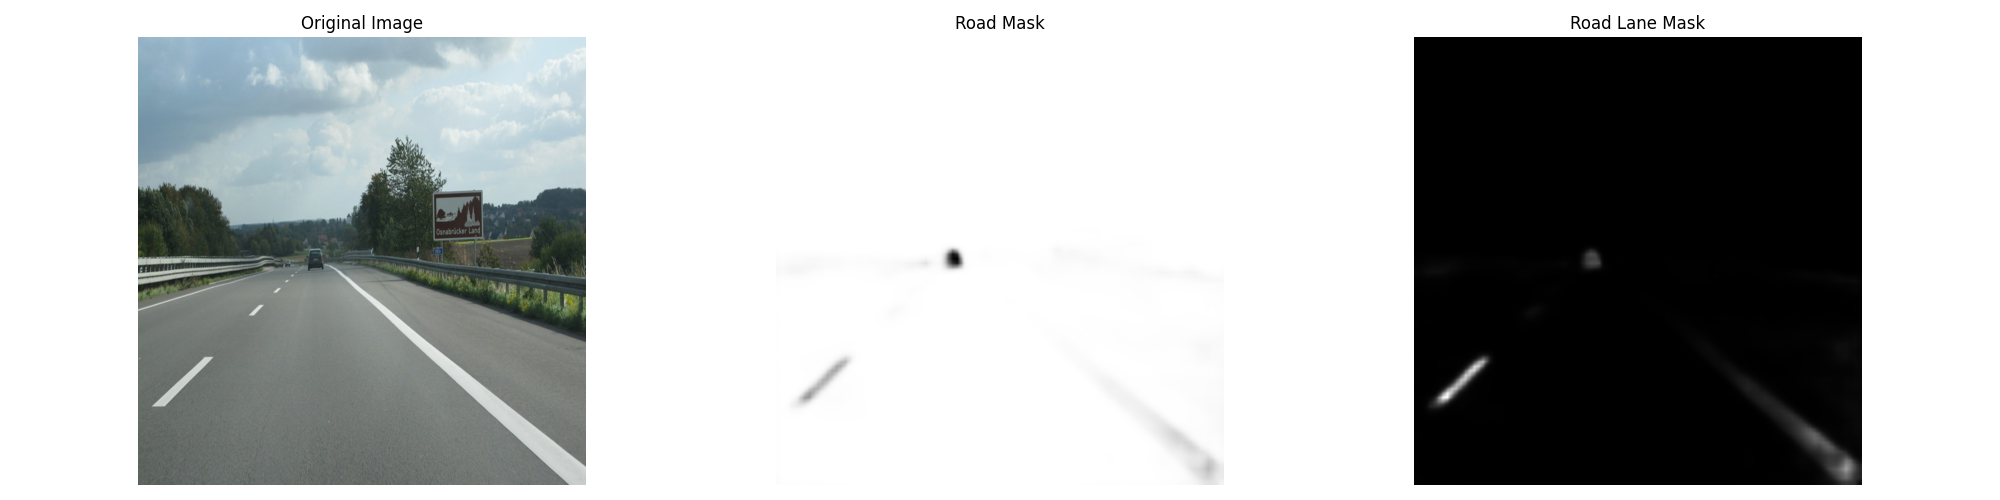

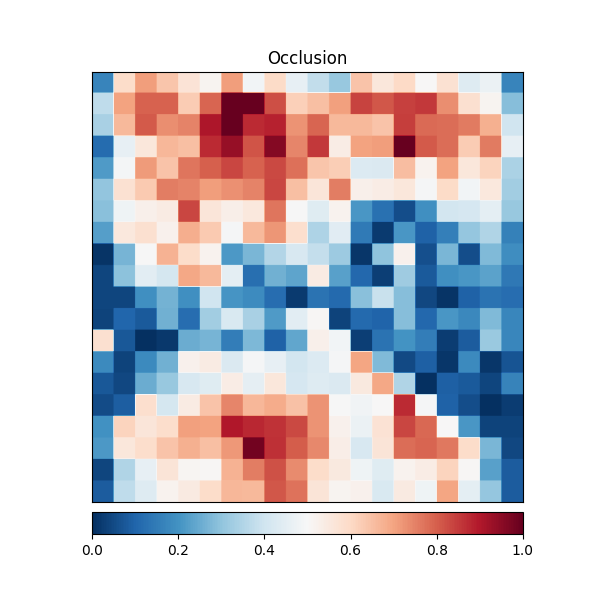

In [ ]:
from captum.attr import IntegratedGradients, visualization as viz
import numpy as np

# Create a figure with a fixed size and horizontal distance between subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Display the original image
axes[0].imshow(img.resize((800, 800)))
axes[0].set_title('Original Image')

# Display the road mask
axes[1].imshow(road_mask, cmap='gray')
axes[1].set_title('Road Mask')

# Display the road lane mask
axes[2].imshow(road_lane_mask, cmap='gray')
axes[2].set_title('Road Lane Mask')

# Remove ticks and labels from subplots
for ax in axes:
    ax.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

_ = viz.visualize_image_attr(np.transpose(attr_occlusion.squeeze().cpu().detach().numpy(), (1,2,0)), show_colorbar=True, title='Occlusion', method="heat_map", cmap='RdBu_r')
